# 金融风控-贷款违约预测

## 一、项目介绍

本次项目来自[阿里天池](https://tianchi.aliyun.com/competition/entrance/531830/introduction)，以金融风控中的个人信贷为背景，要求根据贷款申请人的数据信息预测其是否有违约的可能，以此判断是否通过此项贷款，这是一个典型的分类问题。
项目数据集包含及其描述如下（'isDefault’字段为预测值字段，1表示违约，0表示不违约；其余为特征值字段)：

字段|描述
---|:--:
id|为贷款清单分配的唯一信用证标识
loanAmnt|贷款金额
term|贷款期限（year）
interestRate|贷款利率
installment|分期付款金额
grade|贷款等级
subGrade|贷款等级之子级
employmentTitle|就业职称
employmentLength|就业年限（年）
homeOwnership|借款人在登记时提供的房屋所有权状况
annualIncome|年收入
verificationStatus|验证状态
issueDate|贷款发放的月份
purpose|借款人在贷款申请时的贷款用途类别
postCode|借款人在贷款申请中提供的邮政编码的前3位数字
regionCode|地区编码
dti|债务收入比
delinquency_2years|借款人过去2年信用档案中逾期30天以上的违约事件数
ficoRangeLow|借款人在贷款发放时的fico所属的下限范围
ficoRangeHigh|借款人在贷款发放时的fico所属的上限范围
openAcc|借款人信用档案中未结信用额度的数量
pubRec|贬损公共记录的数量
pubRecBankruptcies|公开记录清除的数量
revolBal|信贷周转余额合计
revolUtil|循环额度利用率，或借款人使用的相对于所有可用循环信贷的信贷金额
totalAcc|借款人信用档案中当前的信用额度总数
initialListStatus|贷款的初始列表状态
applicationType|表明贷款是个人申请还是与两个共同借款人的联合申请
earliesCreditLine|借款人最早报告的信用额度开立的月份
title|借款人提供的贷款名称
policyCode|公开可用的策略_代码=1新产品不公开可用的策略_代码=2
n系列匿名特征|匿名特征n0-n14，为一些贷款人行为计数特征的处理

## 二、读取训练集、测试集并拼接

In [1]:
#导入函数库和数据
import numpy as np
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#读取训练集
train=pd.read_csv('train.csv')
#读取测试集
testA=pd.read_csv('testA.csv')

In [3]:
#查看数据集规模：训练集800000条数据，47个字段；测试集200000条数据，46个字段）
print(train.shape,testA.shape)

(800000, 47) (200000, 46)


In [4]:
#查看训练集和测试集的字段，训练集多出来的一个字段为预测字段 'isDefault'
print(train.columns,'\n',testA.columns)

Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership',
       'annualIncome', 'verificationStatus', 'issueDate', 'isDefault',
       'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',
       'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n11', 'n12', 'n13', 'n14'],
      dtype='object') 
 Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership',
       'annualIncome', 'verificationStatus', 'issueDate', 'purpose',
       'postCode', 'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow',
       'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptc

In [5]:
#为了统一对训练集、测试集特征字段进行处理，将二者进行拼接，拼接前测试集添加'isDefault'字段，暂时用0填充
testA['isDefault']=0
df=pd.concat([train,testA])
print(df.shape)

(1000000, 47)


## 三、数据概览

In [6]:
#查看数据概览，部分字段存在缺失值
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 199999
Data columns (total 47 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1000000 non-null  int64  
 1   loanAmnt            1000000 non-null  float64
 2   term                1000000 non-null  int64  
 3   interestRate        1000000 non-null  float64
 4   installment         1000000 non-null  float64
 5   grade               1000000 non-null  object 
 6   subGrade            1000000 non-null  object 
 7   employmentTitle     999999 non-null   float64
 8   employmentLength    941459 non-null   object 
 9   homeOwnership       1000000 non-null  int64  
 10  annualIncome        1000000 non-null  float64
 11  verificationStatus  1000000 non-null  int64  
 12  issueDate           1000000 non-null  object 
 13  isDefault           1000000 non-null  int64  
 14  purpose             1000000 non-null  int64  
 15  postCode        

In [7]:
#计算缺失值占比情况
def missing_value_table(df):
    #计算所有的缺失值
    mis_val = df.isnull().sum()
    # %比
    mis_val_percent = 100*df.isnull().sum()/len(df)
    #合并
    mis_val_table = pd.concat([mis_val,mis_val_percent],axis=1)
    mis_val_rename = mis_val_table.rename(columns = {0:'Missing values',1:'% of total values'})
    #剔除完整的并排序
    mis_val_rename = mis_val_rename[mis_val_rename.iloc[:,1]!=0].sort_values('% of total values',ascending=False)
    return mis_val_rename
missing_value_table(df)

,Missing values,% of total values
n11,87327,8.7327
employmentLength,58541,5.8541
n8,50382,5.0382
n14,50381,5.0381
n13,50381,5.0381
n12,50381,5.0381
n9,50381,5.0381
n0,50381,5.0381
n1,50381,5.0381
n2,50381,5.0381


In [8]:
#查看数据类型分布
df.dtypes.value_counts()

float64    33
int64       9
object      5
dtype: int64

In [9]:
#查看object类型数据类型数
df.select_dtypes('object').apply(pd.Series.nunique,axis=0)

grade                  7
subGrade              35
employmentLength      11
issueDate            139
earliesCreditLine    726
dtype: int64

## 四、结合各字段业务含义进行数值编码

### 1、逐个考察每个字段后，对下表中的字段进行初步处理

字段|描述|从业务角度进行分类|处理方式
---|:--:|:--:|:--:
id|为贷款清单分配的唯一信用证标识|无序类别型|无实际意义，删除
grade|贷款等级|有序类别型|转换为数值
subGrade|贷款等级之子级|有序类别型|转换为数值
employmentTitle|就业职称|无序类别型|转化为object
employmentLength|就业年限（年）|数值型|转化为数值
homeOwnership|借款人在登记时提供的房屋所有权状况|无序类别型|转化为object
verificationStatus|验证状态|无序类别型|转化为object
issueDate|贷款发放的月份|数值型|拆分为年数值、月数值两列
purpose|借款人在贷款申请时的贷款用途类别|无序类别型|转化为object
postCode|借款人在贷款申请中提供的邮政编码的前3位数字|无序类别型|转化为object
regionCode|地区编码|无序类别型|转化为object
ficoRangeLow|借款人在贷款发放时的fico所属的下限范围|数值型|二者平均值作为新的字段
ficoRangeHigh|借款人在贷款发放时的fico所属的上限范围|数值型|
initialListStatus|贷款的初始列表状态|无序类别型|转化为object
applicationType|表明贷款是个人申请还是与两个共同借款人的联合申请|无序类别型|转化为object
earliesCreditLine|借款人最早报告的信用额度开立的月份|数值型|拆分为年数值、月数值两列
title|借款人提供的贷款名称|无序类别型|转化为object
policyCode|公开可用的策略_代码=1新产品不公开可用的策略_代码=2|无序类别型|所有值都是1，无有效信息，删除

In [10]:
#删除'id','policyCode'字段
df=df.drop(['id','policyCode'],axis=1)

In [11]:
#‘贷款等级’是有高低顺序的，转化为数值格式
df['grade']=df['grade'].replace(['A','B','C','D','E','F','G'],[1,2,3,4,5,6,7])

In [12]:
#‘贷款等级之子级’中的字母表示的信息在‘贷款等级’字段已经有了，将其删除。然后将剩下的数字转化为数值格式
import re
regex_pat = re.compile(r'[A-Z]', flags=re.IGNORECASE)
df['subGrade']=df['subGrade'].str.replace(regex_pat,'',regex=True).astype('int64')

In [13]:
#'就业年限（年）'是有大小之分的，将其转化为数值，并做缺失值填充处理
df['employmentLength']=df['employmentLength'].str.replace(' years','').str.replace(' year','').str.replace('+','').replace('< 1',0)
df['employmentLength']=df['employmentLength'].fillna(10).astype('int64')

In [14]:
#‘借款人在登记时提供的房屋所有权状况’、‘验证状态’、‘借款人在贷款申请时的贷款用途类别’、‘地区编码’等是没有大小之分的，转化为object格式
df['homeOwnership']=df['homeOwnership'].astype('object')
df['verificationStatus']=df['verificationStatus'].astype('object')
df['purpose']=df['purpose'].astype('object')
df['regionCode']=df['regionCode'].astype('object')
df['employmentTitle']=df['employmentTitle'].astype('object')
df['postCode']=df['postCode'].astype('object')
df['initialListStatus']=df['initialListStatus'].astype('object')
df['applicationType']=df['applicationType'].astype('object')
df['title']=df['title'].astype('object')

In [15]:
#'贷款发放的月份'字段转化为时间格式之后可以发现其日全部为1,为多余信息,直接去除，年份信息、月份信息作为新的两个字段
pd.to_datetime(df['issueDate']).dt.day.value_counts()
df['issueYear']=pd.to_datetime(df['issueDate']).dt.year
df['issueMonth']=pd.to_datetime(df['issueDate']).dt.month
del df['issueDate']

In [16]:
#添加earliesCreditLine_Month，earliesCreditLine_Year两字段，删除earliesCreditLine字段
df['earliesCreditLine_Month']=df['earliesCreditLine'].str.split('-',expand=True)[0].replace(
    ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],[1,2,3,4,5,6,7,8,9,10,11,12])
df['earliesCreditLine_Year']=df['earliesCreditLine'].str.split('-',expand=True)[1].astype('int64')
del df['earliesCreditLine']

In [17]:
#借款人在贷款发放时的fico的范围替换为中间值
df['fico']=(df['ficoRangeLow']+df['ficoRangeHigh'])/2
del df['ficoRangeLow']
del df['ficoRangeHigh']

### 2、处理object字段

In [18]:
#查看object字段，有少量缺失值
df.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   employmentTitle     999999 non-null   object
 1   homeOwnership       1000000 non-null  object
 2   verificationStatus  1000000 non-null  object
 3   purpose             1000000 non-null  object
 4   postCode            999999 non-null   object
 5   regionCode          1000000 non-null  object
 6   initialListStatus   1000000 non-null  object
 7   applicationType     1000000 non-null  object
 8   title               999999 non-null   object
dtypes: object(9)
memory usage: 76.3+ MB


In [19]:
df['employmentTitle']

0            320
1         219843
2          31698
3          46854
4             54
           ...  
199995    330967
199996     38930
199997    282016
199998        97
199999       320
Name: employmentTitle, Length: 1000000, dtype: object

In [20]:
#查看有缺失值的字段各自出现频率最高的值
for i in ['employmentTitle','postCode','title']:
    print(df[i].value_counts())

54.0        63978
38.0        15878
32.0        14522
184.0        7639
151.0        6533
            ...  
245537.0        1
245536.0        1
245533.0        1
245532.0        1
183433.0        1
Name: employmentTitle, Length: 298101, dtype: int64
134.0    11092
19.0     10716
51.0     10189
31.0      9188
4.0       8966
         ...  
894.0        1
921.0        1
922.0        1
923.0        1
940.0        1
Name: postCode, Length: 935, dtype: int64
0.0        491400
4.0        185386
5.0         55782
6.0         49628
3.0         18035
            ...  
40390.0         1
40387.0         1
40386.0         1
40385.0         1
30083.0         1
Name: title, Length: 47903, dtype: int64


In [21]:
#缺失值填充
df['employmentTitle']=df['employmentTitle'].fillna('54')
df['postCode']=df['postCode'].fillna('134')
df['title']=df['title'].fillna('0')

In [22]:
#查看object字段各自类别数量
print(df.select_dtypes('object').apply(pd.Series.nunique,axis=0))

employmentTitle       298102
homeOwnership              6
verificationStatus         3
purpose                   14
postCode                 936
regionCode                51
initialListStatus          2
applicationType            2
title                  47904
dtype: int64


#### 对类别数大于10的，采用频率编码，小于10的，采用独热编码

### 3、频率编码

In [23]:
feature_list=['employmentTitle','purpose','postCode','regionCode','title']

In [24]:
for feature in feature_list:
    df[feature]=df[feature].map(df[feature].value_counts())

### 4、独热编码

In [25]:
#剩余object字段各自的类别数比较少，采用独热编码的方式
print(df.select_dtypes('object').apply(pd.Series.nunique,axis=0))

homeOwnership         6
verificationStatus    3
initialListStatus     2
applicationType       2
dtype: int64


In [26]:
df=pd.get_dummies(df)

In [27]:
#检查字段类型，所有字段已完成数值编码
df.dtypes.value_counts()

float64    28
int64      14
uint8      13
dtype: int64

## 五、选取子数据集，解决数据分布不均衡问题

### 1、考察预测值字段'isDefault'的分布，可以看到两种特征分布不均衡

Text(0.5, 1.0, 'Default Distributions \n (0: notDefault || 1: isDefault)')

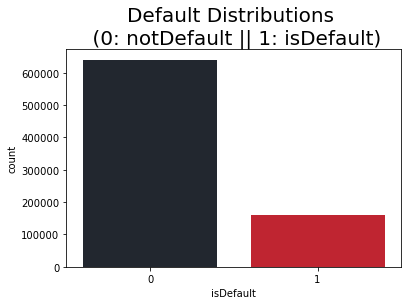

In [28]:
colors=['#202731','#D90B1C']
sns.countplot('isDefault',data=df.iloc[0:800000,:],palette=colors)
plt.title('Default Distributions \n (0: notDefault || 1: isDefault)', fontsize=20)

### 2、通过选取部分数据的方式，使预测值字段均衡

In [29]:
#打乱训练集数据
sub_df = df.iloc[0:800000,:].sample(frac=1,random_state=42)
#提取所有'isDefault'字段为1的行
isDefault = sub_df.loc[sub_df['isDefault'] == 1]
#提取与1相同数量的'isDefault'字段为0的行
notDefault = sub_df.loc[sub_df['isDefault'] == 0][:len(isDefault)]
#拼接后打乱
sub_df = pd.concat([isDefault, notDefault]).sample(frac=1, random_state=42)
sub_df.shape

(319220, 55)

Text(0.5, 1.0, 'Default Distributions \n (0: notDefault || 1: isDefault)')

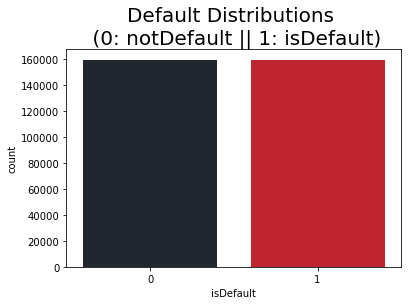

In [30]:
#查看子数据集sub_df中预测值分布，0和1数量相同
colors=['#202731','#D90B1C']
sns.countplot('isDefault',data=sub_df,palette=colors)
plt.title('Default Distributions \n (0: notDefault || 1: isDefault)', fontsize=20)

## 六、缺失值填充、标准化、分割验证集

In [31]:
#使用df数据集训练缺失值填充模型
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(df.drop(columns=['isDefault']))

SimpleImputer(strategy='median')

In [32]:
#使用df数据集训练标准化模型
from sklearn.preprocessing import StandardScaler
std=StandardScaler()
std.fit(df.drop(columns=['isDefault']))

StandardScaler()

In [33]:
#使用训练好的模型将sub_df的特征值字段进行缺失值填充和标准化处理
x=imp.transform(sub_df.drop(columns=['isDefault']))
x=std.transform(x)
#提取预测值字段
y=sub_df['isDefault']

In [34]:
#分割出验证集
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test= train_test_split(x,y,test_size = 0.2,random_state = 0)

## 七、模型预测与评估

In [35]:
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

In [36]:
#逻辑回归模型训练
log_reg = LogisticRegression(C=0.01)
log_reg.fit(x_train,y_train)

LogisticRegression(C=0.01)

In [37]:
#逻辑回归模型预测及评分
predictions = log_reg.predict_proba(x_test)[:,1]
test_auc = roc_auc_score(y_test,predictions)
test_auc

0.7161832672858836

In [38]:
#lightgbm模型训练
model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)

model.fit(x_train, y_train, eval_metric = 'auc',
          eval_set = [(x_test, y_test), (x_train, y_train)],
          eval_names = ['test', 'train'],
          early_stopping_rounds = 100, verbose = 200)

Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.74318	train's binary_logloss: 0.59641	test's auc: 0.732312	test's binary_logloss: 0.604733
[400]	train's auc: 0.756371	train's binary_logloss: 0.585643	test's auc: 0.733919	test's binary_logloss: 0.603302
[600]	train's auc: 0.7674	train's binary_logloss: 0.576576	test's auc: 0.734211	test's binary_logloss: 0.603055
[800]	train's auc: 0.777427	train's binary_logloss: 0.56835	test's auc: 0.734413	test's binary_logloss: 0.602891
Early stopping, best iteration is:
[879]	train's auc: 0.781184	train's binary_logloss: 0.565241	test's auc: 0.734481	test's binary_logloss: 0.602835


LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=10000,
               objective='binary', random_state=50, reg_alpha=0.1,
               reg_lambda=0.1, subsample=0.8)

In [39]:
#lightgbm模型预测及评分
predictions2 = model.predict_proba(x_test)[:,1]
test_auc2 = roc_auc_score(y_test,predictions2)
test_auc2

0.7344806887249563

## 八、预测测试集

In [40]:
#使用训练好的模型将测试集的特征值字段进行缺失值填充和标准化处理
xA=imp.transform(df.iloc[800000:1000000,:].drop(columns=['isDefault']))
xA=std.transform(xA)

In [41]:
#使用最佳模型并预测输出文件
predictionsA = model.predict_proba(xA)[:,1]
submit=pd.read_csv('testA.csv')
submit['isDefault'] = predictionsA
submit.to_csv('prediction.csv', index=False)